In [27]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)

import config

# Calibration


In [164]:

# # k=2/2.7
# k=1
# calib_coeff = 443.2048098506353 /k# pe per volt
# integral_1pe =  0.790754 *k
# amplitude_1pe = 0.0053041233*k

k=1
calib_coeff = 481.83544930923387 /k# pe per volt
integral_1pe =  0.83 *k
amplitude_1pe = 0.0049922196*k

AMPLITUDE_TO_CHARGE = calib_coeff*amplitude_1pe

# Scintillator Data

In [283]:
# filename = config.scope+"coincidence_preamp_v5/1_scintillator_light_output_test.joblib"
# filename = config.scope+"coincidence_preamp_v5/3_scintillator_light_output_test_newSiPM.joblib"
# filename = config.scope+"coincidence_preamp_v5/4_short_long_bar.joblib"
# filename = config.scope+"coincidence_preamp_v5/5_scintillator_41V_2.joblib"
# filename = config.scope+"coincidence_preamp_v5/6_scintillator_41V_two_fiber.joblib"
# filename = config.scope+"coincidence_preamp_v5/6_scintillator_41V_two_fiber_again.joblib"

# filename = config.scope+"coincidence_preamp_v5/8_tripple_channel_41V_trial2_0.joblib"
# filename = config.scope+"coincidence_preamp_v5/9_tripple_channel_41.7V_trial2_0.joblib"
filename = config.scope+"coincidence_preamp_v5/18_old_bar_cosmic_0.joblib"





data_save = joblib.load(filename)
time_series = data_save["metadata"]["time_series"]*1e9

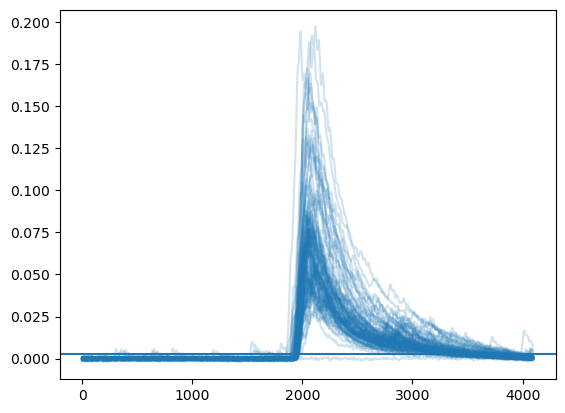

In [284]:
i=2

for i in range(100):
    plot(data_save[2][i], alpha=0.2, color="C0")
    # plot(data_save[2][i])

# plot(scipy.ndimage.gaussian_filter(data_save[2][i], 7))


trigger_threshold_edge = amplitude_1pe*.5
axhline(trigger_threshold_edge)


In [285]:
threshold_npe = 1.5
trigger_threshold_edge = [amplitude_1pe*threshold_npe, amplitude_1pe*threshold_npe]

trace_length = len(data_save[2][0])
pre_trig = trace_length//2-400




process_result = {}
for ch in [1,2]:
    process_result[f"trigger_time_edge_{ch}"]=[]
    process_result[f"trigger_time_cfd_{ch}"]=[]
    process_result[f"trigger_time_fit_{ch}"]=[]
    process_result[f"amplitude_{ch}"]=[]
    process_result[f"integral_{ch}"]=[]
    process_result[f"amplitude_fit_{ch}"]=[]
    process_result[f"trise_fit_{ch}"]=[]
    process_result[f"tfall_fit_{ch}"]=[]
    process_result[f"fit_chi2_{ch}"]=[]
    process_result[f"triggered_{ch}"]=[]
    

for i in tqdm(range(len(data_save[2]))):
# for i in tqdm(range(1000)):
    for ch in [1,2]:
        x=time_series
        y=data_save[ch][i]
        y-=np.mean(y[pre_trig-800:pre_trig])
        # y=scipy.ndimage.gaussian_filter(y, 5)

        dt = (time_series[1]-time_series[0])
        

        # Edge trigger:
        # trigger_time_edge = (np.argmax( y>trigger_threshold_edge[ch-1])-2048)*dt
        trigger_points, *_ = hp.Trigger.threshold_trigger(y[pre_trig:], trigger_threshold_edge[ch-1])
        triggered = len(trigger_points)>0
        trigger_time_edge = dt*(trigger_points[0]+ pre_trig - trace_length//2) if len(trigger_points)>0 else -999


        amplitude = np.max(y[(x>trigger_time_edge)&(x<trigger_time_edge+100)]) if len(trigger_points)>0 else -999
        integral = np.sum(y[(x>trigger_time_edge)&(x<trigger_time_edge+100)]) if len(trigger_points)>0 else -999
        
        process_result[f"trigger_time_edge_{ch}"].append(trigger_time_edge)
        process_result[f"amplitude_{ch}"].append(amplitude)
        process_result[f"integral_{ch}"].append(integral)
        process_result[f"triggered_{ch}"].append(triggered)

        
for key in process_result:
    process_result[key]=np.array(process_result[key])  


dt = process_result[f"trigger_time_edge_1"]-process_result[f"trigger_time_edge_2"]     
amp_min = np.min([process_result["amplitude_2"],process_result["amplitude_1"]],axis=0) 
amp_max = np.max([process_result["amplitude_2"],process_result["amplitude_1"]],axis=0) 
amp_mean = np.mean([process_result["amplitude_2"],process_result["amplitude_1"]],axis=0) 
mask_valid =  (process_result["trigger_time_edge_1"]!=-999) &(process_result["trigger_time_edge_1"]<60)\
            & (process_result["trigger_time_edge_2"]!=-999) &(process_result["trigger_time_edge_2"]<60)\
            & (amp_min>amplitude_1pe*.5)& (amp_max>amplitude_1pe*1.5)

pe_ch1 =  process_result[f"amplitude_1"]*calib_coeff
pe_ch2 =  process_result[f"amplitude_2"]*calib_coeff
pe_ch1_int =  process_result[f"integral_1"]/integral_1pe
pe_ch2_int =  process_result[f"integral_2"]/integral_1pe
pe_min   = np.min([pe_ch1, pe_ch2],axis=0) 
pe_mean = np.mean([pe_ch1, pe_ch2],axis=0) 


process_result["dt"] = dt
process_result["amp_min"] = amp_min
process_result["amp_mean"] = amp_mean
process_result["pe_ch1_int"] = pe_ch1_int
process_result["pe_ch2_int"] = pe_ch2_int
process_result["pe_ch1"] = pe_ch1
process_result["pe_ch2"] = pe_ch2
process_result["pe_min"] = pe_min

joblib.dump(process_result, os.path.splitext(filename)[0]+"_processed.joblib")

100%|██████████| 250/250 [00:00<00:00, 19784.83it/s]


['/mnt/sda2//scope_data/coincidence_preamp_v5/18_old_bar_cosmic_0_processed.joblib']

(0.0, 50.0)

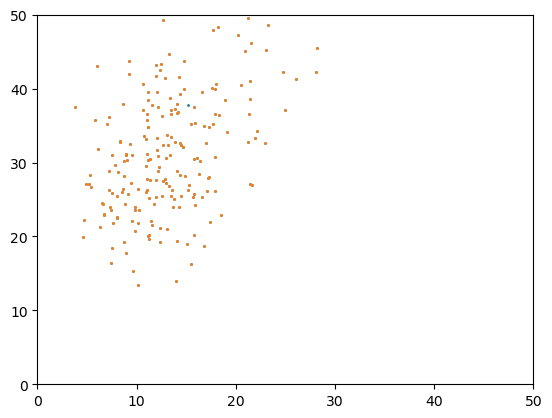

In [286]:
scatter(pe_ch1,pe_ch2, s=1);
scatter(pe_ch1[mask_valid],pe_ch2[mask_valid], s=1);

xlim(0,50)
ylim(0,50)

In [277]:
# scatter(pe_min[mask_valid], dt[mask_valid], s=1, alpha=0.5)
# ylim(17,40)
# show()
# hist(dt[mask_valid], range=(15,40), bins=100);
# hist(dt[mask_valid & (pe_min>10)], range=(20,40), bins=100);

In [278]:
# bins=np.linspace(0,50,100)
# hist(pe_ch2[mask_valid], bins=bins, histtype="step", label="Calib. with amplitude")
# hist(pe_ch2_int[mask_valid], bins=bins, histtype="step", label="Calib. with integral")
# xlabel("Total charge")
# legend()
# ylim(0,70)
# # savefig(config.scope+"plots/Spectrum_cosmic_calibration_comparison.jpg")

In [279]:
# amp_trigger = np.array([np.max(trace) for trace in data_save[3]])
# hist(amp_trigger, bins=100, range=(0,0.25));
# hist(amp_trigger[mask_valid], bins=100, range=(0,0.25));
# xlabel("Amplitude of trigger channel [mV]")
# show()


# trigger_mask_cosmic = amp_trigger>0.1
# sum(trigger_mask_cosmic)

# hist(process_result["pe_ch1"][mask_valid&trigger_mask_cosmic], bins=bins,alpha=0.5, color="C0");
# hist(process_result["pe_ch2"][mask_valid&trigger_mask_cosmic], bins=bins,alpha=0.5, color="C1");
# print(np.mean(process_result["pe_ch1"][mask&trigger_mask_cosmic]))
# print(np.mean(process_result["pe_ch2"][mask&trigger_mask_cosmic]))
# xlabel("Total charge [pe]")


15.350636523830865 0.4740704207184906
37.50960134539057 1.0761546505619188
228 250


(15.350636523830865, 37.50960134539057, 2.4435209111465412)

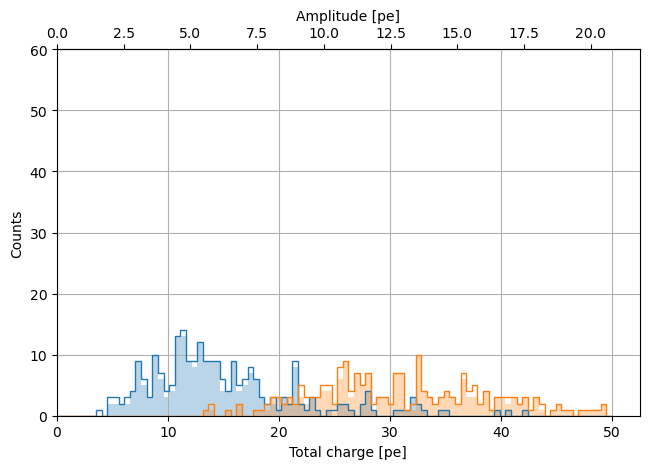

In [287]:
mask = (abs(dt-24)<5) & mask_valid
# mask =  mask_valid

bins=np.linspace(0,50,100)
hist(process_result["pe_ch1"], bins=bins,histtype="step");
hist(process_result["pe_ch2"], bins=bins,histtype="step");
hist(process_result["pe_ch1"][mask], bins=bins,alpha=0.3, color="C0");
hist(process_result["pe_ch2"][mask], bins=bins,alpha=0.3, color="C1");
ylim(0,60)
xlabel("Total charge [pe]")

def amp_to_charge(x):
    return x*AMPLITUDE_TO_CHARGE
def charge_to_amplitude(x):
    return x/AMPLITUDE_TO_CHARGE

secax_x = gca().secondary_xaxis(
    "top", functions=(charge_to_amplitude, amp_to_charge))
secax_x.set_xlabel("Amplitude [pe]")
tight_layout()
xlim(0,)
ylim(0,)
grid()
ylabel("Counts")
# savefig(config.scope+"plots/cosmic_coincidence_test.jpg")



# hist(process_result["pe_ch1"][mask&trigger_mask_cosmic], bins=bins,alpha=0.5, color="C0");
# hist(process_result["pe_ch2"][mask&trigger_mask_cosmic], bins=bins,alpha=0.5, color="C1");
print(np.mean(process_result["pe_ch1"][mask]), scipy.stats.sem(process_result["pe_ch1"][mask]))
print(np.mean(process_result["pe_ch2"][mask]), scipy.stats.sem(process_result["pe_ch2"][mask]))


print(sum(mask), len(mask))
np.mean(process_result["pe_ch1"][mask]), np.mean(process_result["pe_ch2"][mask]), np.mean(process_result["pe_ch2"][mask])/np.mean(process_result["pe_ch1"][mask])

[ 10.85415049   3.83610283 117.30243107]
[ 24.09500638   7.22832285 100.67837156]


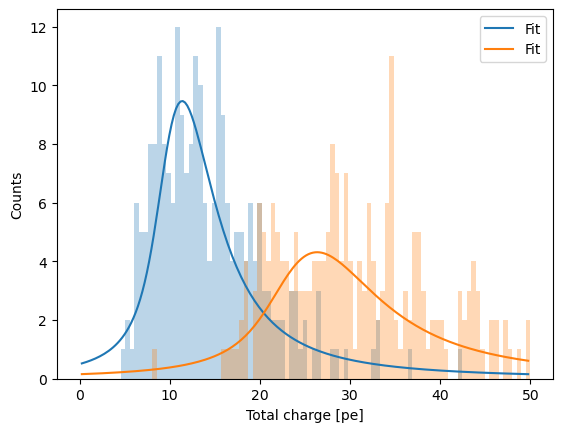

In [262]:
first_hist=hist(process_result["pe_ch1"][mask], bins=bins,alpha=0.3, color="C0");
second_hist=hist(process_result["pe_ch2"][mask], bins=bins,alpha=0.3, color="C1");
vec_landau = np.vectorize(hp.landau)
popt, pcov, info, f = hp.fit_hist(vec_landau, first_hist, fit_range=(0,50),p0=[9,3,len(process_result["pe_ch1"][mask])], color="C0");
print(popt)
popt, pcov, info, f = hp.fit_hist(vec_landau, second_hist, fit_range=(0,50),p0=[25,5,len(process_result["pe_ch2"][mask])], color="C1");
print(popt)
legend()
xlabel("Total charge [pe]")
ylabel("Counts")
show()

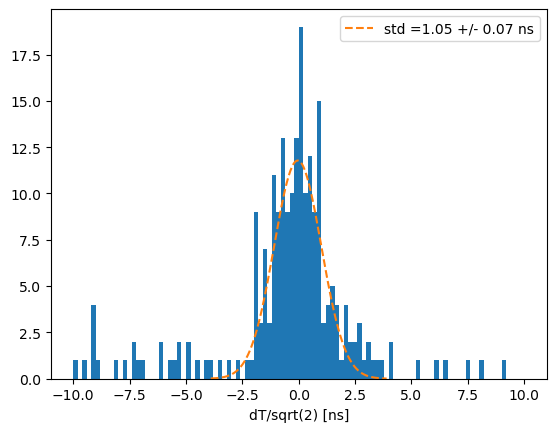

In [281]:
# scatter(pe_mean, dt,s=1)
# xlim(0,40)
# ylim(-10,10)
# xlabel("Charge [pe]")
# ylabel("dt [ns]")
# show()

mask = mask_valid #(process_result["pe_ch1"]>4) & (process_result["pe_ch2"]>4)

h=hist((dt[mask]-24)/sqrt(2), range=(-10,10),bins=100);
popt, pcov, info, f = hp.fit_hist("gauss", h, fit_range=(-4,4), label="std ={popt[2]:.2f} +/- {sqrt(pcov[2,2]):.2f} ns", color="C1", linestyle="--");
legend()
xlabel("dT/sqrt(2) [ns]")
show()

[ 0.08351844 11.30196366 10.72012891]


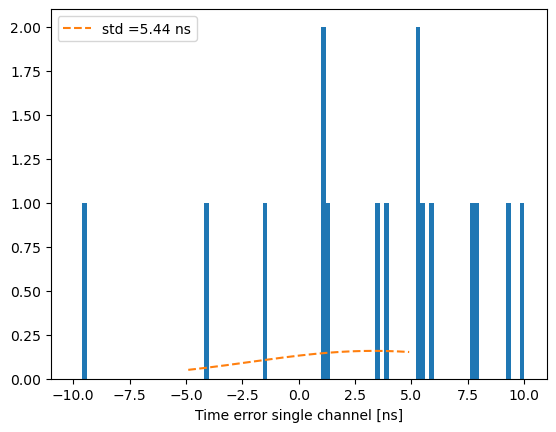

[0.20198718 0.38323765 0.39763379]


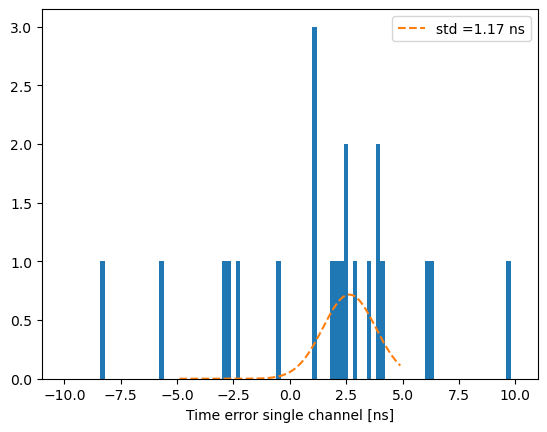

[0.43305157 0.09236103 0.09211738]


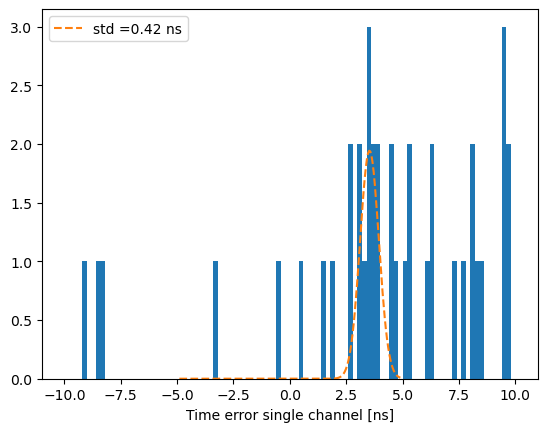

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

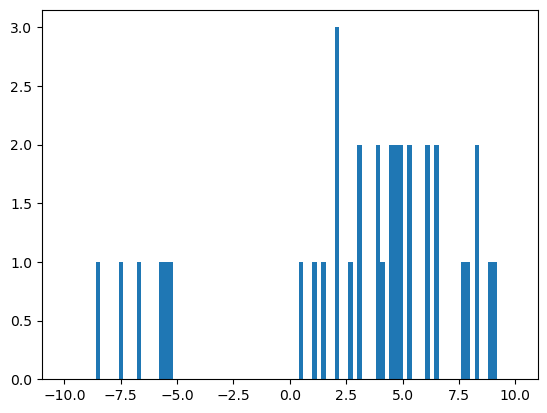

In [19]:
# mask = amp>0.02

# h=hist(dt[mask]/sqrt(2), range=(-10,10),bins=100);
# popt, pcov, info, f = hp.fit_hist("gauss", h, fit_range=(-3,3), label="std ={popt[2]:.2f} ns", color="C1", linestyle="--");
# legend()
# xlabel("Time error single channel [ns]")
# show()

# cut_edges = np.linspace(7,40,10)
cut_edges = [10,13,16,20,25,32,40,60]
amps = []
amps_min = []
sigmas = []


for icut  in range(len(cut_edges)-1):
    # mask = (pe_min>cut_edges[icut])&(pe_min<cut_edges[icut+1])
    mask = (pe_mean>cut_edges[icut])&(pe_mean<cut_edges[icut+1])

    h=hist(dt[mask]/sqrt(2), range=(-10,10),bins=100);

    popt, pcov, info, f = hp.fit_hist("gauss", h, fit_range=(-5,5), label="std ={popt[2]:.2f} ns", color="C1", linestyle="--");

    amps.append(np.mean(pe_ch2[mask]))
    amps_min.append(np.mean(pe_min[mask]))
    sigmas.append(popt[2])
    print(np.sqrt(np.diag(pcov)))

    legend()
    xlabel("Time error single channel [ns]")
    show()


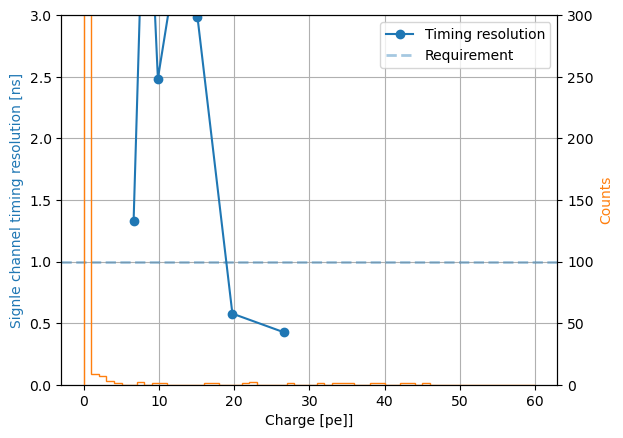

In [129]:


plot(amps_min, sigmas, marker="o", label="Timing resolution")
axhline(1, label="Requirement", color="C0", linewidth=2, alpha=0.4, linestyle="--")

# plot(signal_npe_list, sim_results[1,:, 1])


legend()
ylim(0,3)
xlabel("Charge [pe]]")
ylabel("Signle channel timing resolution [ns]")
grid()
gca().yaxis.label.set_color("C0")


gca().twinx()
hist(pe_ch2[abs(dt)<3],bins=60,range=(0,60),histtype="step",color="C1");
gca().yaxis.label.set_color("C1")
ylabel("Counts")
ylim(0,300)

savefig(os.path.splitext(filename)[0]+"_yield_and_timing_resolution.jpg")
